## GCM-Filters

gcm-filters (https://gcm-filters.readthedocs.io/) uses a laplacian-based method to smooth any field. The method is complementary to corase-granning. For a comparison purpose, we use gcm-filters to compute barotropic vorticity diagnostics at 1-10 degree resolution.

In [1]:
import xarray as xr
import numpy as np
from xgcm import Grid
import regionmask
import gcm_filters
import matplotlib.pyplot as plt

from xmip.preprocessing import combined_preprocessing
from xmip.regionmask import merged_mask
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)

In [5]:
ds_vort = xr.open_dataset("../../Data/OM4p25_JRA55_Vorticity_Budget_1958_2017_Mean.nc")

var_list = ['beta_V', 'BPT', 'Curl_Adv', 'Curl_taus', 'Curl_taub', 
            'Curl_diff', 'Mass_flux', 'Curl_dudt', 'eta_dt']

ds2 = ds_vort.get(var_list).astype(np.float64)
wet_mask = ds_vort['wet_c'].astype(np.float64)
area = ds_vort['areacello_bu'].astype(np.float64)

print(ds2)

<xarray.Dataset>
Dimensions:    (yq: 1080, xq: 1440)
Coordinates:
  * xq         (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yq         (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
Data variables:
    beta_V     (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    BPT        (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_Adv   (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_taus  (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_taub  (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_diff  (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Mass_flux  (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_dudt  (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    eta_dt     (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan


In [6]:
# Let's count number of non-nan grid points in each field

for var in var_list:
    
    tmp = ds2[var]
    
    count_grid = xr.where(np.isnan(tmp), 0.0, 1.0)
    
    print(var, ": Grid points = ", count_grid.sum(['yq','xq']))
    
# since the numner of grid points are not consistent across variables. We need to assign nan to grid points 
# that are not common in variables
# Otherwise, filtered fields will not have a closed vorticity budget near sea-land boundaries.

beta_V : Grid points =  <xarray.DataArray 'beta_V' ()>
array(952747.)
BPT : Grid points =  <xarray.DataArray 'BPT' ()>
array(930170.)
Curl_Adv : Grid points =  <xarray.DataArray 'Curl_Adv' ()>
array(952747.)
Curl_taus : Grid points =  <xarray.DataArray 'Curl_taus' ()>
array(952747.)
Curl_taub : Grid points =  <xarray.DataArray 'Curl_taub' ()>
array(952747.)
Curl_diff : Grid points =  <xarray.DataArray 'Curl_diff' ()>
array(952747.)
Mass_flux : Grid points =  <xarray.DataArray 'Mass_flux' ()>
array(952768.)
Curl_dudt : Grid points =  <xarray.DataArray 'Curl_dudt' ()>
array(952747.)
eta_dt : Grid points =  <xarray.DataArray 'eta_dt' ()>
array(930170.)


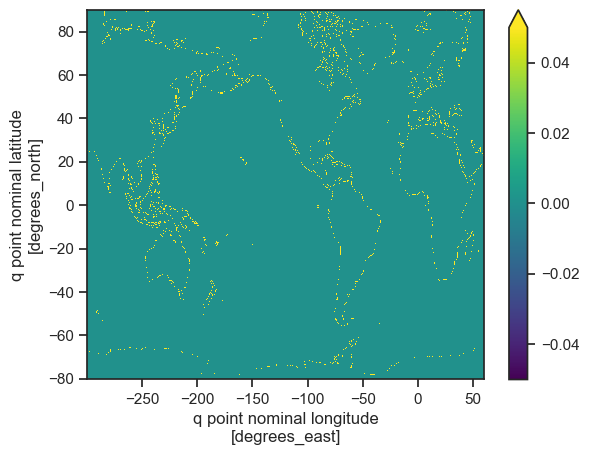

In [7]:
count_grid1 = xr.where(np.isnan(ds2['eta_dt']), 0.0, 1.0)
count_grid2 = xr.where(np.isnan(ds2['beta_V']), 0.0, 1.0)

(count_grid2 - count_grid1).plot(robust=True)

In [8]:
ds3 = ds2.copy()

for var in var_list:
    
    ds3[var] = xr.where(np.isnan(ds2['BPT']), np.nan, ds2[var]) # only keep grid points that have non-nan values for BPT
    
    count_grid = xr.where(np.isnan(ds3[var]), 0.0, 1.0)
    
    print(var, ": Grid points = ", count_grid.sum(['yq','xq']))
    
wet_mask = xr.where(np.isnan(ds2['BPT']), 0., wet_mask)

beta_V : Grid points =  <xarray.DataArray 'beta_V' ()>
array(930170.)
BPT : Grid points =  <xarray.DataArray 'BPT' ()>
array(930170.)
Curl_Adv : Grid points =  <xarray.DataArray 'Curl_Adv' ()>
array(930170.)
Curl_taus : Grid points =  <xarray.DataArray 'Curl_taus' ()>
array(930170.)
Curl_taub : Grid points =  <xarray.DataArray 'Curl_taub' ()>
array(930170.)
Curl_diff : Grid points =  <xarray.DataArray 'Curl_diff' ()>
array(930170.)
Mass_flux : Grid points =  <xarray.DataArray 'Mass_flux' ()>
array(930170.)
Curl_dudt : Grid points =  <xarray.DataArray 'Curl_dudt' ()>
array(930170.)
eta_dt : Grid points =  <xarray.DataArray 'eta_dt' ()>
array(930170.)


In [6]:
print("Mask Grid points = ", wet_mask.sum(['yq','xq']))

Mask Grid points =  <xarray.DataArray ()>
array(930170.)


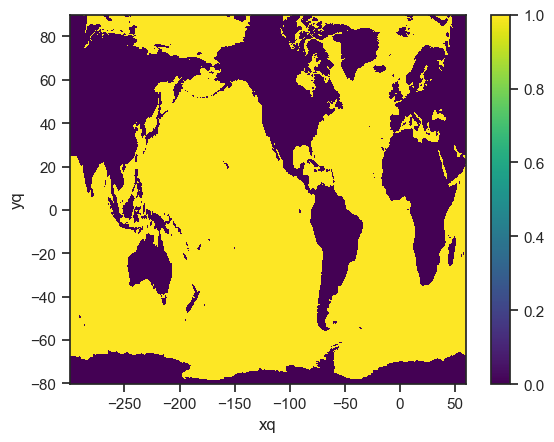

In [9]:
wet_mask.plot()

In [11]:
# use gcm_filters to filter using a fixed coarsening factor

#ds_save = []

#for i in range(1,21):
    
#    factor = 4*i # to i deg
#    dx_min = 1
#    filter_shape = gcm_filters.FilterShape.GAUSSIAN #.TAPER 

#    filter_tripolar_regular_with_land = gcm_filters.Filter(filter_scale=factor, dx_min=1,
#        filter_shape=filter_shape, grid_type=gcm_filters.GridType.TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED,
#        grid_vars={'area': area, 'wet_mask': wet_mask})
    
    #print(filter_tripolar_regular_with_land)
    
#    %time ds_smooth = filter_tripolar_regular_with_land.apply(ds3, dims=['yq', 'xq'])
    
#    ds_save.append(ds_smooth)

    
#ds_save = xr.concat(ds_save, dim='filter_scale')

#ds_save['geolon_c'] = ds_vort['geolon_c']
#ds_save['geolat_c'] = ds_vort['geolat_c']

save_file = "../../Data/GCM_filters/Vorticity_filter_1_20.nc"

ds_save.to_netcdf(save_file)

print("data saved succefully")

data saved succefully


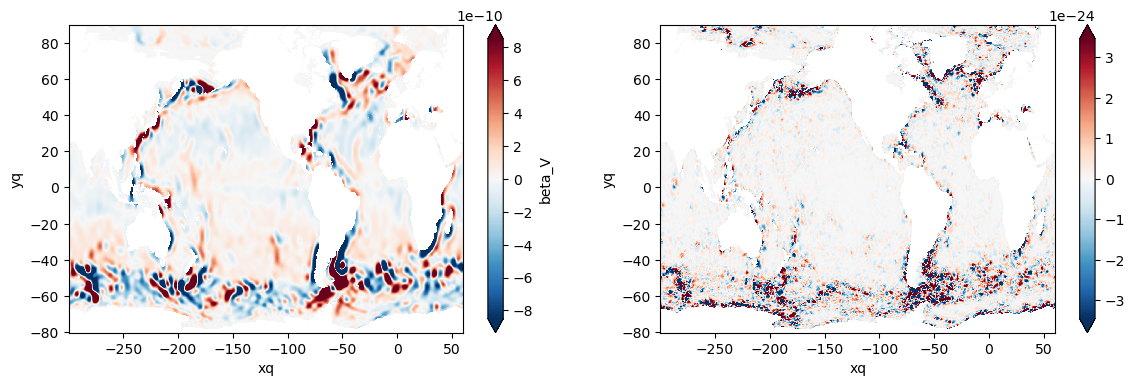

In [30]:
# check the budget is closed after filtering
# This was after we corrected for number of grid points

tmp = ds_save.isel(filter_scale=4)

fig = plt.figure(figsize=[14,4])

plt.subplot(1,2,1)
tmp['beta_V'].plot(robust=True) # this is just noise

tmp = (tmp['beta_V'] - tmp['BPT'] - tmp['Curl_Adv'] - tmp['Curl_taus'] - tmp['Curl_taub'] 
       - tmp['Curl_diff'] - tmp['Mass_flux'] - tmp['Curl_dudt'] - tmp['eta_dt'])

plt.subplot(1,2,2)
tmp.plot(robust=True) # this is just noise

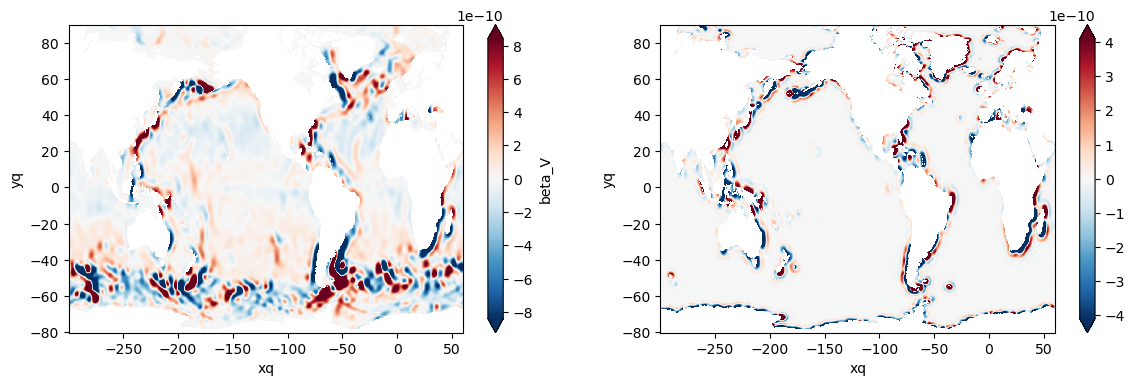

In [14]:
# check the budget is closed after filtering
# This was before we corrected for number of grid points

tmp = ds_save.isel(filter_scale=4)

fig = plt.figure(figsize=[14,4])

plt.subplot(1,2,1)
tmp['beta_V'].plot(robust=True) # this is just noise

tmp = (tmp['beta_V'] - tmp['BPT'] - tmp['Curl_Adv'] - tmp['Curl_taus'] - tmp['Curl_taub'] 
       - tmp['Curl_diff'] - tmp['Mass_flux'] - tmp['Curl_dudt'] - tmp['eta_dt'])

plt.subplot(1,2,2)
tmp.plot(robust=True) # this is just noise

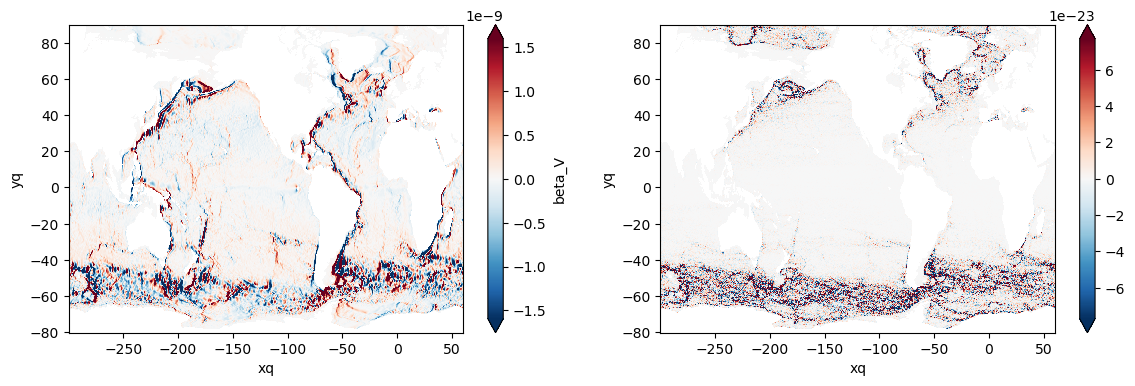

In [31]:
# original data

tmp = ds3

fig = plt.figure(figsize=[14,4])

plt.subplot(1,2,1)
tmp['beta_V'].plot(robust=True) # this is just noise

tmp = (tmp['beta_V'] - tmp['BPT'] - tmp['Curl_Adv'] - tmp['Curl_taus'] - tmp['Curl_taub'] 
       - tmp['Curl_diff'] - tmp['Mass_flux'] - tmp['Curl_dudt'] - tmp['eta_dt'])

plt.subplot(1,2,2)
tmp.plot(robust=True) # this is just noise

### Check circular dipole issue

Coarse-grained fields showed large-scale circular patterns in bottom pressure torque and diffusion terms. Here, we check if the same pattern is present in filtered fields (using gcm-filters).

In [3]:
ds = xr.open_dataset("../../Data/GCM_filters/Vorticity_filter_1_10.nc", chunks={'filter_scale':1})

print(ds)

<xarray.Dataset>
Dimensions:    (filter_scale: 10, yq: 1080, xq: 1440)
Coordinates:
  * xq         (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yq         (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
Dimensions without coordinates: filter_scale
Data variables:
    beta_V     (filter_scale, yq, xq) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    BPT        (filter_scale, yq, xq) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    Curl_Adv   (filter_scale, yq, xq) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    Curl_taus  (filter_scale, yq, xq) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    Curl_taub  (filter_scale, yq, xq) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    Curl_diff  (filter_scale, yq, xq) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    Mass_flux  (filter_scale, yq, xq) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.nd

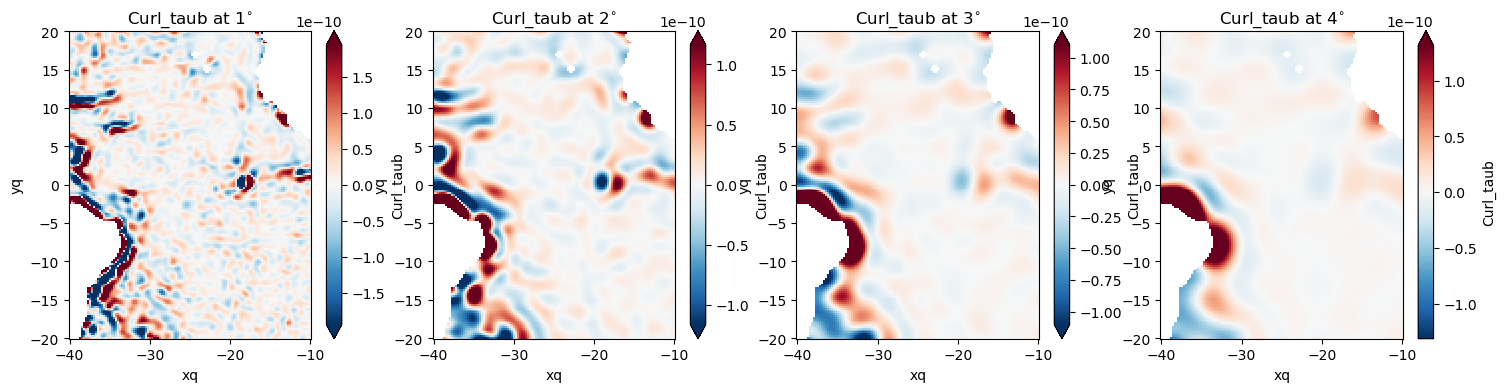

In [6]:
tmp = ds.sel(xq=slice(-40, -10), yq=slice(-20, 20))

fig = plt.figure(figsize=[18,4])

for i in range(0,4):
    plt.subplot(1,4,1+i)
    tmp['Curl_taub'].isel(filter_scale=i).plot(robust=True)
    plt.title('Curl_taub at '+ str(i+1) + r'$^{\circ}$') 
    

### Vorticity balances 

Similar to coarse-graining exercise, we compute vorticity balances in the North Atlantic as a function of filtering length scale.

In [12]:
ds = xr.open_dataset("../../Data/GCM_filters/Vorticity_filter_1_20.nc", chunks={'filter_scale':1})

print(ds)

<xarray.Dataset>
Dimensions:    (filter_scale: 20, yq: 1080, xq: 1440)
Coordinates:
  * xq         (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yq         (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
Dimensions without coordinates: filter_scale
Data variables:
    beta_V     (filter_scale, yq, xq) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    BPT        (filter_scale, yq, xq) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    Curl_Adv   (filter_scale, yq, xq) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    Curl_taus  (filter_scale, yq, xq) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    Curl_taub  (filter_scale, yq, xq) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    Curl_diff  (filter_scale, yq, xq) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    Mass_flux  (filter_scale, yq, xq) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.nd

In [13]:
def plot_sec(ax, da, vmin=-999, vmax=999, vstep=1, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?', aspect_rt = 1.0):
    
    contours = np.arange(vmin, vmax+vstep, vstep)
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    #cb = plt.colorbar(p, ax=ax, extend='both', orientation="horizontal", shrink=0.6)
    #cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    #ax.coastlines()
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylocator = mticker.FixedLocator(np.arange(-80,81,20))
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180,20))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    #ax.set_adjustable('datalim')
    
    ax.set_aspect(aspect_rt)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    ax.add_feature(cfeature.LAND, facecolor='grey')
    #ax.add_feature(cfeature.COASTLINE)
    
    _ = plt.title(title, fontsize=14)
    return p

In [17]:
# Masking 

basins = regionmask.defined_regions.natural_earth.ocean_basins_50

mask = merged_mask(basins, ds, lon_name="geolon_c", lat_name="geolat_c")

mask1 = mask.copy()

mask1 = mask1.where((mask1 <= -1) & (mask1 >= 20.))

mask1 = xr.where((mask==0) | (mask==1), 0., mask1) # Atlantic

mask1 = xr.where((mask==2) | (mask==3), 1., mask1) # Pacific

mask1 = xr.where((mask==4) | (mask==5), 2., mask1) # Indian

mask1 = xr.where((ds['geolat_c'] < -33.) & (mask >= -1) & (mask <= 20.), 3., mask1) # Southern Ocean

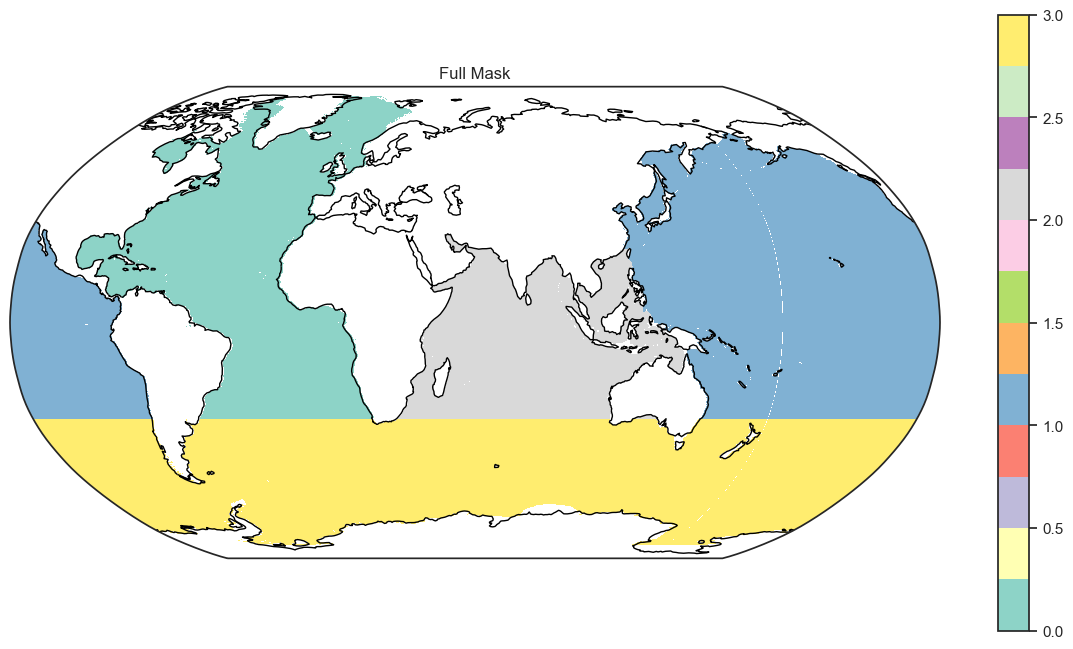

In [20]:
kwargs = dict(x='xq', y='yq',transform = ccrs.PlateCarree(), infer_intervals=False)

fig, ax = plt.subplots(ncols=1, figsize=[15,8], subplot_kw={'projection':ccrs.Robinson(60)})

mask1.plot(cmap='Set3', **kwargs)
ax.set_title(f"Full Mask")
ax.coastlines()

In [23]:
# Example for North Atlantic (30-70 N, Corre et al)
# Standard deviation in scales larger than filter scale

fldlist = ['beta_V', 'BPT','Curl_taus','Curl_taub','Curl_Adv','Curl_diff', 'Rest']

ds1 = ds.where(mask == 0.) 

ds_deg_std = xr.Dataset()

for fld in fldlist:
    
    if (fld == 'Rest'):
        tmp1 = ds1['Mass_flux'] + ds1['eta_dt'] + ds1['Curl_dudt']
        
        tmp = (tmp1 * tmp1).mean(['xq', 'yq'])
    else:
        tmp = (ds1[fld] * ds1[fld]).mean(['xq', 'yq'])
        
    ds_deg_std[fld] = np.sqrt(tmp) # standard deviation

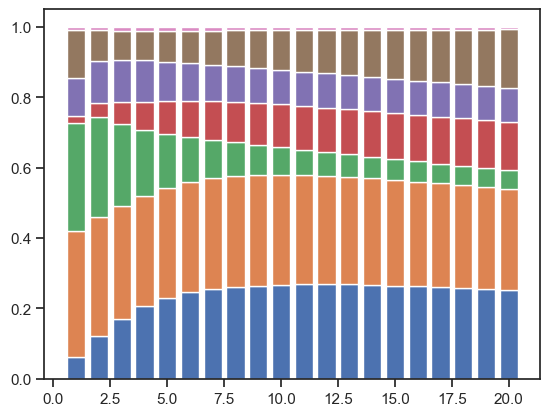

In [24]:
width = 0.8 
d = ds_deg_std
scale = np.arange(d.filter_scale.shape[0]) + 1.0

bot = 0.
    
pos = - 0.0
width = 0.8

var_name = ['beta_V', 'BPT','Curl_Adv', 'Curl_taus', 'Curl_taub', 'Curl_diff', 'Rest']
norm_fac = d['beta_V'] + d['BPT'] + d['Curl_Adv'] + d['Curl_taus'] + d['Curl_taub'] + d['Curl_diff'] + d['Rest']


for var in var_name:
    
    tmp = d[var] / norm_fac
        
    plt.bar(scale + pos, tmp, width, bottom=bot)
        
    pos = pos + 0.*width
        
    bot = bot + tmp